In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from collections import defaultdict
import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]
# 
# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
# df = df[df.localization_node != 'localization_generator']
# df = df[(df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
metrics += ['norm_trajectory_length']
metrics_and_versions += ['norm_trajectory_length']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

# if False:
if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    5034

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['hunter', 'turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

    fixed_rpp                                                              [False, True]

    beta_1                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

## Metrics

    controller_cpu_time                                                    min:       0.67             avg:      80.39             max:       1031             nan:          0

    planner_cpu_time                                                       min:       0.32             avg:      24.16             max:        395             nan:          0

    system_cpu_time                                                        min:       2.59             avg:        115             max:       1303             nan:          0

    controller_max_memory                                                  min:      21.52             avg:       52.4             max:      78.79             nan:          0

    planner_max_memory                                                     min:      22.23             avg:      518.9             max:  3.116e+04             nan:          0

    system_max_memory                                                      min:      132.2             avg:        693             max:  3.134e+04             nan:          0

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length                                                      min:          0             avg:      16.69             max:      133.9             nan:          0

    trajectory_length_version                                              [1]

    execution_time                                                         min:      0.069             avg:      73.16             max:      648.1             nan:          0

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.7034             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:          0             avg:    0.05664             max:      3.312             nan:        861

    odometry_error_alpha_1_std                                             min:          0             avg:    0.06153             max:      14.27             nan:        861

    odometry_error_alpha_2_mean                                            min:          0             avg:    0.06943             max:      9.154             nan:        861

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1276             max:      22.58             nan:        861

    odometry_error_alpha_3_mean                                            min:  1.385e-17             avg:     0.0625             max:     0.7404             nan:        861

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01639             max:      1.071             nan:        861

    odometry_error_alpha_4_mean                                            min:  8.119e-18             avg:     0.2646             max:      1.372             nan:        861

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2319             max:      1.326             nan:        861

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:  0.0009799             avg:    0.09197             max:      2.394             nan:        864

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.04356             max:      2.996             nan:        864

    localization_update_absolute_rotation_error_mean                       min:  0.0001497             avg:    0.02261             max:       1.45             nan:        864

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.03529             max:      1.348             nan:        864

    localization_update_relative_translation_error_mean                    min:  0.0007232             avg:    0.01103             max:     0.2224             nan:        864

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01164             max:      1.124             nan:        864

    localization_update_relative_rotation_error_mean                       min:   5.71e-05             avg:    0.01069             max:     0.3784             nan:        864

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.03487             max:     0.9476             nan:        864

    localization_update_normalized_relative_translation_error_mean         min:   0.001691             avg:     0.0566             max:      1.181             nan:        864

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.06441             max:      9.121             nan:        864

    localization_update_normalized_relative_rotation_error_mean            min:  0.0006716             avg:     0.1902             max:      13.03             nan:        865

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.9109             max:      46.21             nan:        865

    localization_update_error_version                                      [1]

    localization_update_rate                                               min:      0.288             avg:      1.005             max:       37.4             nan:        861

    localization_update_rate_std                                           min:          0             avg:     0.4587             max:      14.34             nan:        861

    localization_update_rate_version                                       [1]

    collision_rate                                                         min:          0             avg:    0.09615             max:          1             nan:          0

    collision_rate_version                                                 [3]

    average_translation_velocity                                           min:  5.858e-05             avg:     0.2363             max:     0.3455             nan:        714

    average_rotation_velocity                                              min:   2.57e-05             avg:     0.1262             max:     0.8558             nan:        714

    motion_characteristics_version                                         [4]

    translation_rotation_product                                           min:  1.505e-09             avg:     0.0279             max:     0.1523             nan:        714

    average_translation_acceleration                                       min:   8.57e-11             avg:     0.1228             max:     0.6255             nan:        723

    average_rotation_acceleration                                          min:  3.719e-11             avg:     0.1746             max:     0.7145             nan:        723

    translation_rotation_acceleration_product                              min:  4.953e-21             avg:    0.03465             max:     0.3641             nan:        723

    clearance                                                              min:        nan             avg:        nan             max:        nan             nan:       5034

    clearance_version                                                      [1]

    minimum_clearance                                                      min:          0             avg:     0.7114             max:      5.819             nan:          0

    average_clearance                                                      min:      1.912             avg:      4.889             max:      12.41             nan:          0

    median_clearance                                                       min:     0.2977             avg:       3.89             max:      11.77             nan:          0

    maximum_clearance                                                      min:      5.433             avg:      22.38             max:      29.82             nan:          0

    average_velocity_atan                                                  min:    0.01083             avg:     0.3817             max:      1.328             nan:        714

    collision_time                                                         min:      7.801             avg:      75.82             max:      420.7             nan:       4550

    absolute_translation_error                                             min:  0.0009799             avg:    0.08933             max:     0.4319             nan:        864

    collisionless_localization_update_absolute_translation_error_std       min:          0             avg:    0.04065             max:     0.1984             nan:        864

    absolute_rotation_error                                                min:  0.0001497             avg:    0.02057             max:     0.2085             nan:        864

    collisionless_localization_update_absolute_rotation_error_std          min:          0             avg:    0.03119             max:     0.7018             nan:        864

    collisionless_localization_update_relative_translation_error_mean      min:  0.0007232             avg:      0.011             max:     0.2224             nan:        864

    collisionless_localization_update_relative_translation_error_std       min:          0             avg:     0.0112             max:      1.124             nan:        864

    collisionless_localization_update_relative_rotation_error_mean         min:   5.71e-05             avg:   0.009963             max:     0.3534             nan:        864

    collisionless_localization_update_relative_rotation_error_std          min:          0             avg:     0.0328             max:     0.9476             nan:        864

    normalized_relative_translation_error                                  min:   0.001691             avg:    0.05376             max:     0.3406             nan:        864

    collisionless_localization_update_normalized_relative_translation_error_std min:          0             avg:    0.05516             max:     0.9488             nan:        864

    normalized_relative_rotation_error                                     min:  0.0006716             avg:     0.1889             max:      13.03             nan:        865

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:     0.8998             max:      46.21             nan:        865

    collisionless_localization_update_error_version                        [1]

    average_velocity                                                       min:          0             avg:     0.1848             max:     0.2681             nan:          0

    collisionless_success_rate                                             min:          0             avg:     0.6655             max:          1             nan:          0

    norm_trajectory_length                                                 min:          0             avg:     0.8954             max:      10.16             nan:          0

    norm_execution_time                                                    min:  0.0007583             avg:     0.9993             max:      12.47             nan:          0

In [6]:

localization_input_target_components = [
    'localization_node',
    'local_planner_node',
    'global_planner_node',
]
localization_input_component_features = [
    'amcl_alpha_factor',
]
localization_input_system_features = [
    'beta_1',
    'robot_model',
    'max_steering_angle_deg',
]
localization_input_performance_features = [
    'average_translation_velocity',
    'average_velocity_atan',
]

localization_output = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]

import copy
class FeatureSelection:
    def __init__(self, name, value, window, is_discrete):
        self.name = name
        self.value = value
        self.window = window
        self.is_discrete = is_discrete
    def __str__(self):
        return f"{self.name} = {self.value}" + (f" ± {self.window}" if self.window is not None else "")
    def get_range(self):
        return [self.value - self.window, self.value + self.window] if self.window is not None else [self.value, self.value]
    def with_value(self, value):
        ret = copy.deepcopy(self)
        ret.value = value
        return ret

def select_data(d, features_in):
    df_select = d
    for f in features_in:
        df_feature = d[d[f.name].between(*f.get_range())]
        df_select = df_select[df_select[f.name].between(*f.get_range())]
        num_feature_datapoints = len(d[d[f.name].between(*f.get_range())])
    return df_select

def plot_predictions_1(d, output, feature_1, fixed_features, n1=20, min_y=None, max_y=None, print_count_and_stuff=False):

    fig = plt.figure()


    x1_ls = np.linspace(d[feature_1.name].min() + feature_1.window, d[feature_1.name].max() - feature_1.window, n1) if not feature_1.is_discrete else sorted(d[feature_1.name].unique())

    y_ds = list(map(lambda x1: select_data(d, fixed_features + [feature_1.with_value(x1)])[output], x1_ls))
    y_mean = list(map(lambda y_ds_i: y_ds_i.mean(), y_ds))

    if print_count_and_stuff:
        print()
        count_and_stuff_ds = pd.DataFrame({
        'x1_ls': x1_ls,
        'y_mean': y_mean,
        'y_std': list(map(lambda y_ds_i: y_ds_i.std(), y_ds)),
        'y_count': list(map(lambda y_ds_i: y_ds_i.count(), y_ds)),
        })
        print(count_and_stuff_ds)    
    
    d_scatter_1 = select_data(d, fixed_features)
    plt.scatter(d_scatter_1[feature_1.name], d_scatter_1[output], color='gray')
#     print(f"feature_1: {feature_1}")
    d_scatter_2 = select_data(d, fixed_features + [feature_1])
    plt.scatter(d_scatter_2[feature_1.name], d_scatter_2[output], color='blue')
#     print(feature_1, " -> ", d_scatter_2[output].mean())
    
    plt.plot(x1_ls, y_mean, '.-')

    plt.grid()
#     plt.legend()
    plt.xlabel(feature_1.name.replace('_', ' '))
    plt.ylabel(output.replace('_', ' '))
    plt.ylim([min_y, max_y])
    fig.set_size_inches([5, 5])
    plt.show()

def plot_predictions_2(d, output, feature_1, feature_2, fixed_features, n1=20, n2=5, min_y=None, max_y=None, print_count_and_stuff=False):

    fig = plt.figure()

    x2_ls = np.linspace(d[feature_2.name].min() + feature_2.window, d[feature_2.name].max() - feature_2.window, n2) if not feature_2.is_discrete else sorted(d[feature_2.name].unique())

    for x2 in x2_ls:

        x1_ls = np.linspace(d[feature_1.name].min() + feature_1.window, d[feature_1.name].max() - feature_1.window, n1) if not feature_1.is_discrete else sorted(d[feature_1.name].unique())
        
        y_ds = list(map(lambda x1: select_data(d, fixed_features + [feature_2.with_value(x2), feature_1.with_value(x1)])[output], x1_ls))
        y_mean = list(map(lambda y_ds_i: y_ds_i.mean(), y_ds))
        
        if print_count_and_stuff:
            print()
            print(feature_2.with_value(x2))
            count_and_stuff_ds = pd.DataFrame({
            'x1_ls': x1_ls,
            'y_mean': y_mean,
            'y_std': list(map(lambda y_ds_i: y_ds_i.std(), y_ds)),
            'y_count': list(map(lambda y_ds_i: y_ds_i.count(), y_ds)),
            })
            print(count_and_stuff_ds)    
        
        plt.plot(x1_ls, y_mean, '.-', label=f"{feature_2.name.replace('_', ' ')}={x2}")

    plt.grid()
    plt.legend()
    plt.xlabel(feature_1.name.replace('_', ' '))
    plt.ylabel(output.replace('_', ' '))
    plt.ylim([min_y, max_y])
    fig.set_size_inches([5, 5])
    plt.show()

# def estimate_from_data(d, output, features_in):  ## not used
#     selected_df = select_data(d, features_in)
#     return selected_df[output_name].mean()

features_in = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    
    FeatureSelection(name='amcl_alpha_factor', value=1.0, window=None, is_discrete=True),
    
    FeatureSelection(name='beta_1', value=0.02, window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
    
    FeatureSelection(name='average_translation_velocity', value=0.2362, window=0.02, is_discrete=False),
    FeatureSelection(name='average_velocity_atan', value=0.3816, window=0.1, is_discrete=False),
]
selected_df = select_data(df, features_in)

printmd("### in:")
for f in features_in:
    print(f"{str(f):<70} num feature datapoints: {len(df[df[f.name].between(*f.get_range())])}")

printmd("### out:")
print(f"num datapoints: {len(selected_df)}")
for output_name in localization_output:
    print(f"{output_name:<70} min: {selected_df[output_name].min():.5f} mean: {selected_df[output_name].mean():.5f} max: {selected_df[output_name].max():.5f} std: {selected_df[output_name].std():.5f}")


### in:

localization_node = amcl                                               num feature datapoints: 5034
local_planner_node = dwb                                               num feature datapoints: 944
global_planner_node = navfn                                            num feature datapoints: 3520
amcl_alpha_factor = 1.0                                                num feature datapoints: 1329
beta_1 = 0.02                                                          num feature datapoints: 1571
robot_model = turtle                                                   num feature datapoints: 4280
max_steering_angle_deg = 90.0                                          num feature datapoints: 3522
average_translation_velocity = 0.2362 ± 0.02                           num feature datapoints: 1516
average_velocity_atan = 0.3816 ± 0.1                                   num feature datapoints: 1715


### out:

num datapoints: 12
absolute_translation_error                                             min: 0.02355 mean: 0.03775 max: 0.05800 std: 0.01222
absolute_rotation_error                                                min: 0.00424 mean: 0.00948 max: 0.01770 std: 0.00424
normalized_relative_translation_error                                  min: 0.01666 mean: 0.02646 max: 0.03530 std: 0.00544
normalized_relative_rotation_error                                     min: 0.01756 mean: 0.02707 max: 0.03596 std: 0.00549


### 1D localization -> local planner

localization_node = amcl
local_planner_node = dwb
global_planner_node = navfn
robot_model = turtle
max_steering_angle_deg = 90.0
beta_1 = 0.02
average_translation_velocity = 0.3 ± 0.02
absolute_translation_error   -> 0.07606955448935857
                             -> 0.014822568318776088 ,  0.15154581671915562


### 2D localization -> local planner

localization_node = amcl
local_planner_node = dwb
global_planner_node = navfn
robot_model = turtle
max_steering_angle_deg = 90.0
beta_1 = 0.02


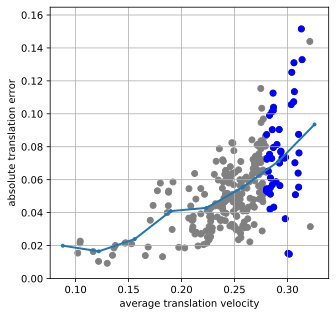

### 1D local planner -> localization

localization_node = amcl
local_planner_node = dwb
global_planner_node = navfn
robot_model = turtle
max_steering_angle_deg = 90.0
beta_1 = 0.02
absolute_translation_error = 0.07606955448935857 ± 0.02
average_translation_velocity -> 0.2667073286279644
                             -> 0.1799985832720018 ,  0.3108614086297932


### 2D local planner -> localization

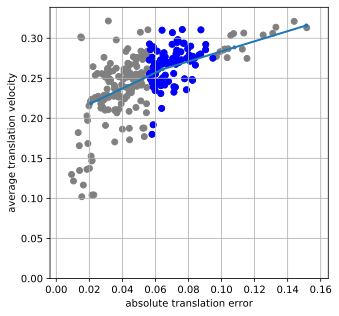

In [7]:
localization_fixed_features = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
    FeatureSelection(name='beta_1', value=0.02, window=None, is_discrete=True),
]

# amcl_alpha_factor_f = FeatureSelection(name='amcl_alpha_factor', value=1.0, window=None, is_discrete=True)
# average_velocity_atan_f = FeatureSelection(name='average_velocity_atan', value=0.1, window=0.1, is_discrete=False)

printmd("### 1D localization -> local planner")
average_translation_velocity_f = FeatureSelection(name='average_translation_velocity', value=0.3, window=0.02, is_discrete=False)
print('\n'.join(map(str, localization_fixed_features + [average_translation_velocity_f])))
d_out = select_data(df, localization_fixed_features + [average_translation_velocity_f])
print("absolute_translation_error   ->", d_out['absolute_translation_error'].mean())
print("                             ->", d_out['absolute_translation_error'].min(), ', ', d_out['absolute_translation_error'].max())
localization_out = d_out['absolute_translation_error'].mean()

printmd("### 2D localization -> local planner")
print('\n'.join(map(str, localization_fixed_features)))
plot_predictions_1(
    d=df,
    output='absolute_translation_error',
    feature_1=average_translation_velocity_f,
    fixed_features=localization_fixed_features,
    n1=10,
    min_y=0.0,
)

printmd("### 1D local planner -> localization")
absolute_translation_error_f = FeatureSelection(name='absolute_translation_error', value=d_out['absolute_translation_error'].mean(), window=0.02, is_discrete=False)
print('\n'.join(map(str, localization_fixed_features + [absolute_translation_error_f])))
d_out = select_data(df, localization_fixed_features + [absolute_translation_error_f])
print("average_translation_velocity ->", d_out['average_translation_velocity'].mean())
print("                             ->", d_out['average_translation_velocity'].min(), ', ', d_out['average_translation_velocity'].max())
local_planner_out = d_out['average_translation_velocity'].mean()

printmd("### 2D local planner -> localization")
plot_predictions_1(
    d=df,
    output='average_translation_velocity',
    feature_1=absolute_translation_error_f,
    fixed_features=localization_fixed_features,
    n1=10,
    min_y=0.0,
)


average_translation_velocity = 0.3 ± 0.02 -> absolute_translation_error   min: 0.01482   mean: 0.07607   max: 0.15155


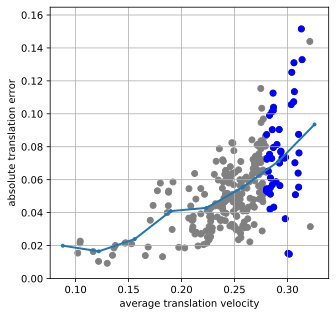

absolute_translation_error = 0.07606955448935857 ± 0.02 -> average_translation_velocity   min: 0.18000   mean: 0.26671   max: 0.31086
average_translation_velocity = 0.2667073286279644 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05927   max: 0.11539


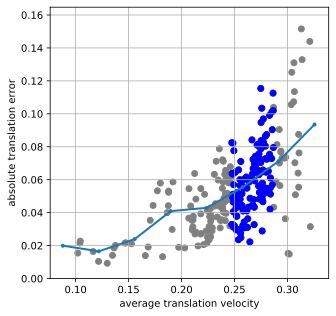

absolute_translation_error = 0.05927476724078621 ± 0.02 -> average_translation_velocity   min: 0.17315   mean: 0.25725   max: 0.31086
average_translation_velocity = 0.25725268015541264 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05523   max: 0.11539


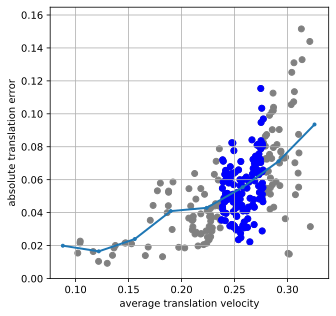

absolute_translation_error = 0.05522840088084552 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25358   max: 0.31055
average_translation_velocity = 0.253580684962513 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05245   max: 0.08418


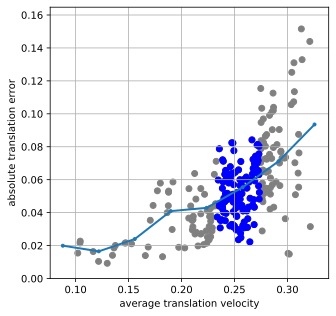

absolute_translation_error = 0.05245448865976944 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25178   max: 0.31055
average_translation_velocity = 0.2517764729175674 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05151   max: 0.08418


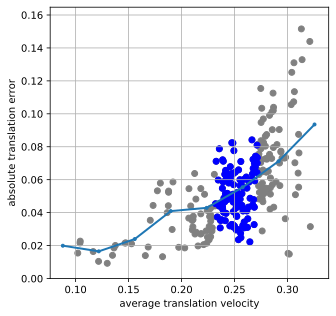

absolute_translation_error = 0.0515095547626498 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25114   max: 0.31055
average_translation_velocity = 0.2511438621005725 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05072   max: 0.08418


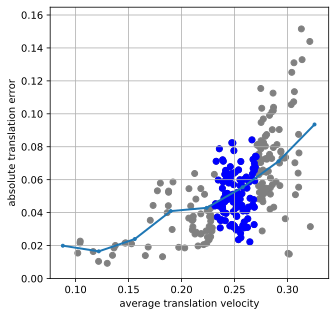

absolute_translation_error = 0.050717824722454036 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25141   max: 0.32157
average_translation_velocity = 0.2514077006520174 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05110   max: 0.08418


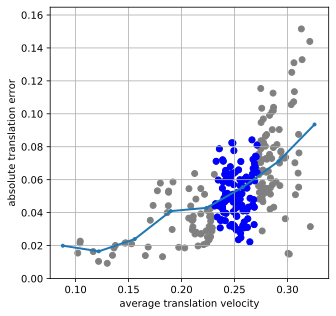

absolute_translation_error = 0.051096231347197964 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25155   max: 0.32157
average_translation_velocity = 0.2515485380223174 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05132   max: 0.08418


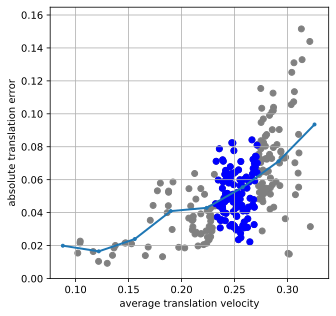

absolute_translation_error = 0.05132117436821158 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25138   max: 0.32157
average_translation_velocity = 0.2513757261045086 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05110   max: 0.08418


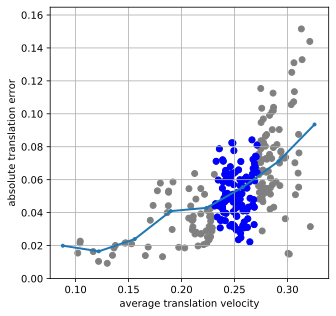

absolute_translation_error = 0.051096231347197964 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25155   max: 0.32157
average_translation_velocity = 0.2515485380223174 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05132   max: 0.08418


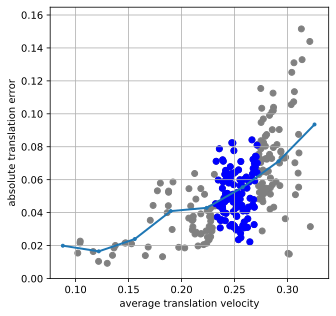

absolute_translation_error = 0.05132117436821158 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25138   max: 0.32157
average_translation_velocity = 0.2513757261045086 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05110   max: 0.08418


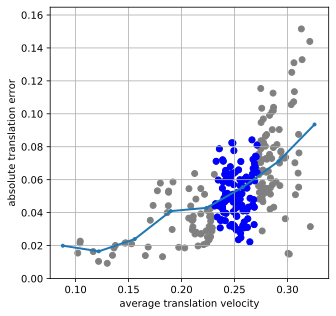

absolute_translation_error = 0.051096231347197964 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25155   max: 0.32157
average_translation_velocity = 0.2515485380223174 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05132   max: 0.08418


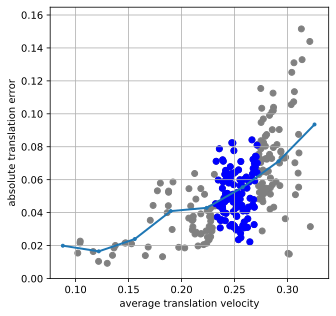

absolute_translation_error = 0.05132117436821158 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25138   max: 0.32157
average_translation_velocity = 0.2513757261045086 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05110   max: 0.08418


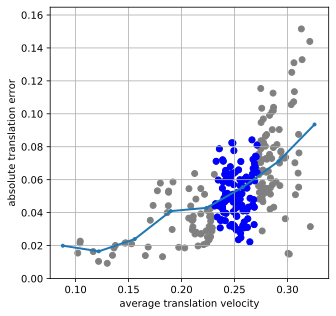

absolute_translation_error = 0.051096231347197964 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25155   max: 0.32157
average_translation_velocity = 0.2515485380223174 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05132   max: 0.08418


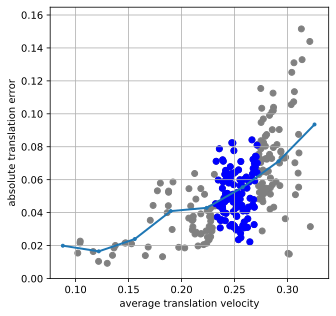

absolute_translation_error = 0.05132117436821158 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25138   max: 0.32157
average_translation_velocity = 0.2513757261045086 ± 0.02 -> absolute_translation_error   min: 0.02224   mean: 0.05110   max: 0.08418


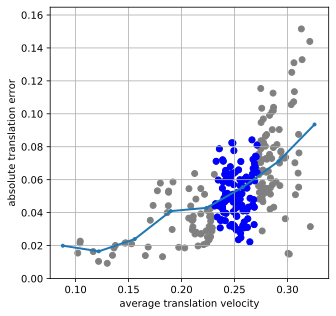

absolute_translation_error = 0.051096231347197964 ± 0.02 -> average_translation_velocity   min: 0.17047   mean: 0.25155   max: 0.32157


In [8]:
localization_fixed_features = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
    FeatureSelection(name='beta_1', value=0.02, window=None, is_discrete=True),
]

# amcl_alpha_factor_f = FeatureSelection(name='amcl_alpha_factor', value=1.0, window=None, is_discrete=True)
# average_velocity_atan_f = FeatureSelection(name='average_velocity_atan', value=0.1, window=0.1, is_discrete=False)

average_translation_velocity_f = FeatureSelection(name='average_translation_velocity', value=0.3, window=0.02, is_discrete=False)

for i in range(15):
    localization_out = select_data(df, localization_fixed_features + [average_translation_velocity_f])['absolute_translation_error']
    print(f"{average_translation_velocity_f} -> absolute_translation_error   min: {localization_out.min():.5f}   mean: {localization_out.mean():.5f}   max: {localization_out.max():.5f}")
    absolute_translation_error_f = FeatureSelection(name='absolute_translation_error', value=localization_out.mean(), window=0.02, is_discrete=False)

    plot_predictions_1(
        d=df,
        output='absolute_translation_error',
        feature_1=average_translation_velocity_f,
        fixed_features=localization_fixed_features,
        n1=10,
        min_y=0.0,
    )

    local_planner_out = select_data(df, localization_fixed_features + [absolute_translation_error_f])['average_translation_velocity']
    print(f"{absolute_translation_error_f} -> average_translation_velocity   min: {local_planner_out.min():.5f}   mean: {local_planner_out.mean():.5f}   max: {local_planner_out.max():.5f}")
    average_translation_velocity_f = FeatureSelection(name='average_translation_velocity', value=local_planner_out.mean(), window=0.02, is_discrete=False)

#     printmd("### 2D local planner -> localization")
#     plot_predictions_1(
#         d=df,
#         output='average_translation_velocity',
#         feature_1=absolute_translation_error_f,
#         fixed_features=localization_fixed_features,
#         n1=10,
#         min_y=0.0,
#     )


localization_node = amcl, local_planner_node = dwb, global_planner_node = navfn, robot_model = turtle, max_steering_angle_deg = 90.0


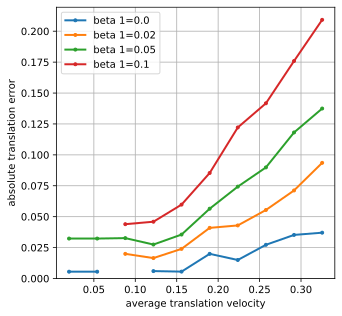

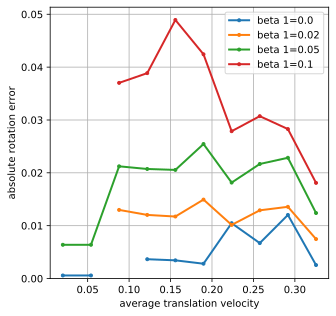

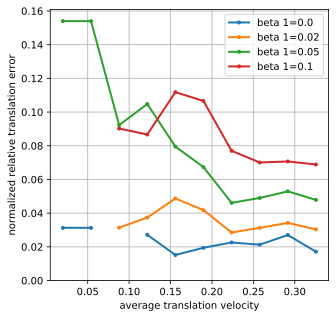

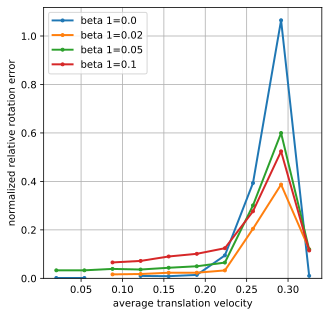

localization_node = amcl, local_planner_node = dwb, global_planner_node = navfn, robot_model = turtle, max_steering_angle_deg = 90.0


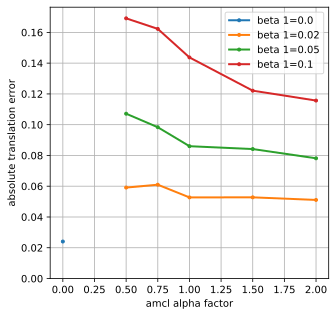

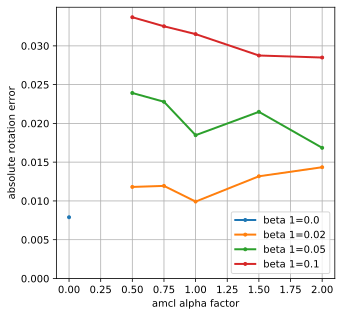

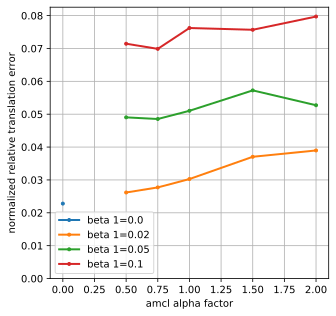

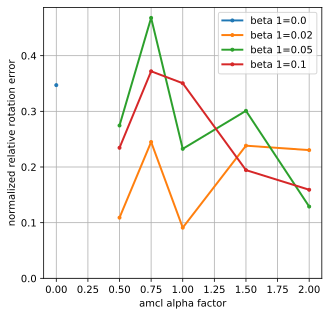

localization_node = amcl, local_planner_node = dwb, global_planner_node = navfn, robot_model = turtle, max_steering_angle_deg = 90.0


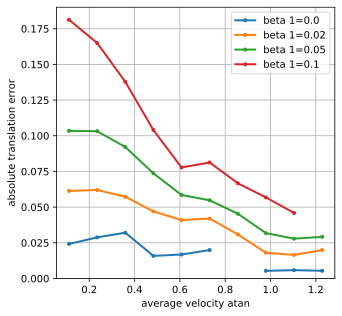

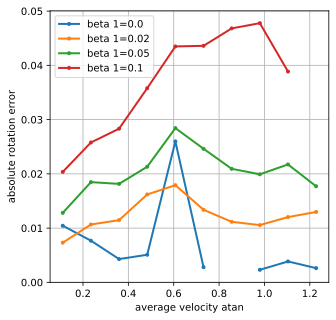

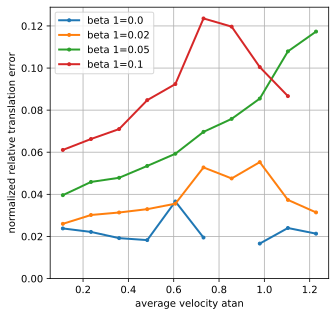

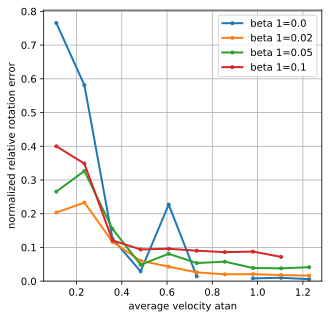

In [9]:
localization_fixed_features = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
]

amcl_alpha_factor_f = FeatureSelection(name='amcl_alpha_factor', value=1.0, window=None, is_discrete=True)
beta_1_f = FeatureSelection(name='beta_1', value=0.02, window=None, is_discrete=True)

average_translation_velocity_f = FeatureSelection(name='average_translation_velocity', value=None, window=0.02, is_discrete=False)
average_velocity_atan_f = FeatureSelection(name='average_velocity_atan', value=None, window=0.1, is_discrete=False)

localization_output = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]

print(', '.join(map(str, localization_fixed_features)))
for output in localization_output:
    plot_predictions_2(
        d=df,
        output=output,
        feature_1=average_translation_velocity_f,
        feature_2=beta_1_f,
        fixed_features=localization_fixed_features,
        n1=10,
        n2=5,
        min_y=0.0,
    )

print(', '.join(map(str, localization_fixed_features)))
for output in localization_output:
    plot_predictions_2(
        d=df,
        output=output,
        feature_1=amcl_alpha_factor_f,
        feature_2=beta_1_f,
        fixed_features=localization_fixed_features,
        n1=10,
        n2=5,
        min_y=0.0,
    )

print(', '.join(map(str, localization_fixed_features)))
for output in localization_output:
    plot_predictions_2(
        d=df,
        output=output,
        feature_1=average_velocity_atan_f,
        feature_2=beta_1_f,
        fixed_features=localization_fixed_features,
        n1=10,
        n2=5,
        min_y=0.0,
    )
